In [1]:
# Load the libraries
from __future__ import print_function

import os, sys, gzip, glob, json, time, argparse
import pandas as pd
import numpy as np
import keras
from pandas.io.json import json_normalize

from pandas.io.json import json_normalize
from keras.utils import to_categorical
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler, MinMaxScaler, MaxAbsScaler
from sklearn.preprocessing import LabelEncoder, OneHotEncoder

from keras.utils import to_categorical
from keras import backend as K
from keras.layers import Input, Dense, Dropout, Activation, Conv1D, MaxPooling1D, Flatten
from keras import optimizers
from keras.optimizers import SGD, Adam, RMSprop
from keras.models import Sequential, Model, model_from_json, model_from_yaml
from keras.utils import np_utils
from keras.callbacks import ModelCheckpoint, CSVLogger, ReduceLROnPlateau

from sklearn.linear_model import Lasso, LogisticRegression
from sklearn.feature_selection import SelectFromModel
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

import scanpy as sc 

# Data Preparation   

In [ ]:
# read the merged FPKM file 

df_FPKM_UQ = pd.read_csv("Merged_FPKM-UQ.tsv", low_memory=False, sep="\t")

In [ ]:
# explore the file 
df_FPKM_UQ.iloc[0:6, 0:10]
cols = df_FPKM_UQ.columns[2:].values.tolist()

In [ ]:
# read the file 
submitters_id_to_project_id = pd.read_csv("submitters_id_to_project_id.tsv", 
                                          low_memory=False, sep="\t")


In [ ]:
# explore the contents
submitters_id_to_project_id.columns
submitters_id_to_project_id


In [ ]:
# There are 15 cancer types. 
submitters_id_to_project_id.mappedProject.value_counts()

In [ ]:
# Time elapsed to transpose: ~100 seconds on a modern laptop
dft_FPKM_UQ = df_FPKM_UQ.T

In [ ]:
print('Pre df', df_FPKM_UQ.shape)
print('After df Transpose', dft_FPKM_UQ.shape)

dft_FPKM_UQ[0:2]
dft_FPKM_UQ.index[0:2]

In [ ]:
# We are removing the first two rows (ESG*** and gene_name rows) 
# and saving them in dftm_FPM_UQ

print('Dimension of dft_FPKM_UQ :', dft_FPKM_UQ.shape)
dftm_FPKM_UQ = dft_FPKM_UQ.drop(dft_FPKM_UQ.index[0:2], axis=0)
print('Dimension of dftm_FPKM_UQ :', dftm_FPKM_UQ.shape)

In [ ]:
# view few entries.
dftm_FPKM_UQ.iloc[0:3, 0:15]
dft_FPKM_UQ.iloc[0:5,0:15]
dftm_FPKM_UQ.index

In [ ]:
# Extract the Submitter ID from the index and attach 
# it as a column called Submitter ID

dftm_FPKM_UQ['submitter_id'] = dftm_FPKM_UQ.index
dftm_FPKM_UQ
dftm_FPKM_UQ = dftm_FPKM_UQ.reset_index(drop=True)

dftm_FPKM_UQ.iloc[0:3, 0:12]
dft_FPKM_UQ.iloc[2:5,0:12]

dftm_FPKM_UQ['submitter_id']
dftm_FPKM_UQ.iloc[0:5,60483]

print(submitters_id_to_project_id.iloc[0:3,0:3])
sid_list = submitters_id_to_project_id['submittedAliquot ID'].values.tolist()
type(sid_list)
sid_list.index('TCGA-04-1338-01A-01R-1564-13')


In [ ]:
# explore the file 
dftm_FPKM_UQ.shape

dftm_FPKM_UQ['Project_id'] = ' '
for idx, val in dftm_FPKM_UQ['submitter_id'].items():
    temp_sid = sid_list.index(val)
    dftm_FPKM_UQ['Project_id'][idx] = submitters_id_to_project_id['mappedProject'][temp_sid]


In [ ]:
# checking few random project_id and submitters_ids
dftm_FPKM_UQ[['Project_id','submitter_id']].iloc[[1,100,500,1000,2000,3000,4000],]

print(dftm_FPKM_UQ.shape)
dftm_FPKM_UQ.drop(['submitter_id'], axis = 1,  inplace=True)
print(dftm_FPKM_UQ.shape)
print(len(sid_list))

In [ ]:
# ## Final check before moving on
dftm_FPKM_UQ.Project_id.value_counts()

print( 'before', dftm_FPKM_UQ['Project_id'][0:10] )
le = preprocessing.LabelEncoder()



In [ ]:
# Create a label (category) encoder object
dftm_FPKM_UQ['Project_id'] = le.fit_transform(dftm_FPKM_UQ.Project_id.values)

print( 'end', dftm_FPKM_UQ['Project_id'][0:10] )

print(len(le.classes_))
print(le.classes_)

dftm_FPKM_UQ['Project_id'].value_counts()
dftm_FPKM_UQ.shape
dftm_FPKM_UQ.columns

In [ ]:
# Use to_categorical on your labels
features = dftm_FPKM_UQ.drop(['Project_id'], axis=1)
# pandas.core.series.Series
outcome = dftm_FPKM_UQ.Project_id
print(outcome)
#outcome.to_csv('TC1-outcome-data15.tsv', sep='\t', index=False, header = False)

# Scaling 

In [ ]:
sfeatures = features.div(features.sum(axis=1), axis=0)
sfeatures = sfeatures * 1000000

# log scaling
sfeatures1 = sfeatures.astype(np.float64).apply(np.log10)

# since we have negative numbers
sfeatures1[sfeatures1 < 0] = 0

In [ ]:
# just making sure
sfeatures1.isnull().sum().sum()

# just checking
print('features few entries')
features.iloc[0:5,0:5]

print('sfeatures few entries')
sfeatures.iloc[0:5,0:5]

print('sfeatures1 few entries')
sfeatures1.iloc[0:5,0:5]

In [2]:
# Read features and output files 
TC1data15 = pd.read_csv("TC1-S1-data15.tsv", sep="\t", low_memory = False)
#TC1data15 = sfeatures1

In [3]:
outcome = pd.read_csv('TC1-outcome-data15.tsv', sep='\t',names='y')

In [4]:
#outcome = outcome.values
outcome = outcome['y']

In [ ]:
# sfeatures1.to_csv('TC1-S1-data15.tsv', sep='\t', index=False)

In [5]:
def encode(data): 
    print('Shape of data (BEFORE encode): %s' % str(data.shape))
    encoded = to_categorical(data)
    print('Shape of data (AFTER  encode): %s\n' % str(encoded.shape))
    return encoded



In [ ]:
# from keras.utils import to_categorical
# outcome = encode(outcome)

# Train/Test split 

In [6]:
X_train, X_test, Y_train, Y_test = train_test_split(TC1data15, outcome, 
                                                    train_size=0.75, 
                                                    test_size=0.25, 
                                                    random_state=123, 
                                                    stratify = outcome)

In [7]:
X_train

,0,1,2,3,4,5,6,7,8,9,...,60473,60474,60475,60476,60477,60478,60479,60480,60481,60482
4041,1.689731,0.0,1.688631,0.706529,0.192179,0.579063,0.200649,1.424220,1.368183,1.067280,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2672,1.859938,0.0,1.927208,1.075611,0.516417,1.274908,1.900628,1.856691,1.208173,1.722260,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2330,1.582440,0.0,1.768800,0.913085,0.242484,1.139900,0.961180,1.817495,1.361378,1.321897,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4062,1.863364,0.0,1.798688,0.666591,0.333679,1.013925,0.629035,1.919349,1.308344,1.264655,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2143,1.169325,0.0,2.105297,0.607296,0.762262,0.502276,0.977535,1.851701,1.776100,1.343003,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1834,2.225504,0.0,1.821518,0.955309,0.428499,0.429838,1.984127,1.928211,1.149703,1.518418,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
773,0.992846,0.0,1.846082,0.624370,0.453924,1.957298,1.348092,1.790435,1.204439,1.370231,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1822,1.462670,0.0,2.135943,0.910532,0.947541,0.206601,0.664101,1.881220,1.619200,1.475129,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3303,2.146533,0.0,2.236857,0.848034,0.644243,0.687526,0.749331,1.821978,1.268621,1.588743,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [8]:
Y_train

4041     6
2672    13
2330     5
4062    14
2143     4
        ..
1834    14
773      9
1822    12
3303     0
2857     1
Name: y, Length: 3375, dtype: int64

# Feature Selection(LASSO)

In [ ]:
scaler = StandardScaler()
scaler.fit(X_train)

sel_ = SelectFromModel(LogisticRegression(C=1, penalty='l1',multi_class='multinomial'))
sel_.fit(X_train, Y_train)

In [ ]:
selected_feat = X_train.columns[(sel_.get_support())]
print('total features: {}'.format((X_train.shape[1])))
print('selected features: {}'.format(len(selected_feat)))
print('features with coefficients shrank to zero: {}'.format(
      np.sum(sel_.estimator_.coef_ == 0)))

In [ ]:
X_train_selected_lasso = sel_.transform(X_train.fillna(0))
X_test_selected_lasso = sel_.transform(X_test.fillna(0))
X_train_selected_lasso.shape, X_test_selected_lasso.shape

In [ ]:
X_train_selected_lasso = pd.DataFrame(X_train_selected_lasso)
X_test_selected_lasso = pd.DataFrame(X_test_selected_lasso)

In [ ]:
X_train_selected_lasso.to_csv('X_train_selected_lasso.tsv', sep='\t', index=False)
X_test_selected_lasso.to_csv('X_test_selected_lasso.tsv', sep='\t', index=False)

## CONV1D

In [ ]:
X_train = X_train_selected_lasso
X_test = X_test_selected_lasso

In [ ]:
from keras.utils import to_categorical
Y_train = encode(Y_train)
Y_test = encode(Y_test)

In [ ]:
# parameters  
activation='relu'
batch_size=20
# Number of sites
classes=15
drop = 0.1
feature_subsample = 0
loss='categorical_crossentropy'
# metrics='accuracy'
out_act='softmax'
pool=[1, 10]
# optimizer='sgd'
shuffle = False 
epochs=400

optimizer = optimizers.SGD(lr=0.1)
metrics = ['acc']

# X_train shape: (3375, 60483)
# X_test shape:  (1125, 60483)
# Y_train shape: (3375,1)
# Y_test shape:  (1125,1)

# 60483
x_train_len = X_train.shape[1]   

X_train = np.expand_dims(X_train, axis=2)
X_test = np.expand_dims(X_test, axis=2)

# X_train shape: (3375, 60483, 1)
# X_test shape:  (1125, 60483, 1)


filters = 128 
filter_len = 20 
stride = 1 

# inside pool_list loop
pool_list = [1,10]

K.clear_session()

model = Sequential()

# model.add  CONV1D
model.add(Conv1D(filters = filters, 
                 kernel_size = filter_len, 
                 strides = stride, 
                 padding='valid', 
                 input_shape=(x_train_len, 1)))

# x_train_len = 60,483
# Activation
model.add(Activation('relu'))

# MaxPooling
model.add(MaxPooling1D(pool_size = 1))

filters = 128
filter_len = 10 
stride = 1 
# Conv1D
model.add(Conv1D(filters=filters, 
                 kernel_size=filter_len, 
                 strides=stride, 
                 padding='valid'))
# Activation
model.add(Activation('relu'))

# MaxPooling
model.add(MaxPooling1D(pool_size = 10))
model.add(Flatten())

model.add(Dense(200))

# activation 
# model.add(Activation('relu')) # SR
model.add(Activation(activation))
#dropout
model.add(Dropout(0.1))

model.add(Dense(20))
# activation
# model.add(Activation('relu')) # SR
model.add(Activation(activation))

#dropout
model.add(Dropout(0.1))

model.add(Dense(15))
model.add(Activation(out_act))

model.compile( loss= loss, 
              optimizer = optimizer, 
              metrics = metrics )
model.summary()



In [ ]:
# save
save = '.'
output_dir = "/data/ravichandrans/TC1/Modeling"
          
output_dir = save 
if not os.path.exists(output_dir): 
    os.makedirs(output_dir)

model_name = 'tc1'
path = '{}/{}.autosave.model.h5'.format(output_dir, model_name)
checkpointer = ModelCheckpoint(filepath=path, 
                               verbose=1, 
                               save_weights_only=False, 
                               save_best_only=True)
          
csv_logger = CSVLogger('{}/training.log'.format(output_dir))



In [ ]:
# SR: change epsilon to min_delta
reduce_lr = ReduceLROnPlateau(monitor='val_loss', 
                              factor=0.1, 
                              patience=10, 
                              verbose=1, mode='auto', 
                              min_delta=0.0001, 
                              cooldown=0, 
                              min_lr=0)


In [ ]:
# batch_size = 20 
history = model.fit(X_train, Y_train, batch_size=batch_size, 
                    epochs=epochs, verbose=1, validation_data=(X_test, Y_test), 
                    callbacks = [checkpointer, csv_logger, reduce_lr])

score = model.evaluate(X_test, Y_test, verbose=0)

## Finish up save model weights

In [ ]:
print('Test score:', score[0])
print('Test accuracy:', score[1])

# serialize weights to HDF5
model.save_weights("{}/{}.model.h5".format(output_dir, model_name))
print("Saved model to disk")

# load weights into new model
loaded_model_yaml.load_weights('{}/{}.model.h5'.format(output_dir, model_name))
print("Loaded yaml model from disk")

# evaluate loaded model on test data
loaded_model_yaml.compile(loss=loss,optimizer=optimizer, metrics=metrics) 
score_yaml = loaded_model_yaml.evaluate(X_test, Y_test, verbose=0)

print('yaml Test score:', score_yaml[0])
print('yaml Test accuracy:', score_yaml[1])

print("yaml %s: %.2f%%" % (loaded_model_yaml.metrics_names[1], score_yaml[1]*100))



# Feature Selection(Genetic Algorithm)

In [ ]:
from sklearn import linear_model
from feature_selection_ga import FeatureSelectionGA, FitnessFunction

model = linear_model.LogisticRegression(solver='lbfgs', multi_class='auto')
fsga = FeatureSelectionGA(model,np.array(X_train),Y_train, ff_obj = FitnessFunction())


In [ ]:
pop = fsga.generate(100)

In [ ]:
pop

# Feature Selection(PCA)

In [11]:
pca = PCA(0.95)
fit = pca.fit(X_train)

In [12]:
X_train_selected_pca = pca.transform(X_train)
X_test_selected_pca = pca.transform(X_test)

In [13]:
X_train_selected_pca.shape, X_test_selected_pca.shape

((3375, 1586), (1125, 1586))

In [21]:
X_train_selected_pca = pd.DataFrame(X_train_selected_pca)
X_test_selected_pca = pd.DataFrame(X_test_selected_pca)

In [22]:
X_train_selected_pca

,0,1,2,3,4,5,6,7,8,9,...,1576,1577,1578,1579,1580,1581,1582,1583,1584,1585
0,47.917401,9.180459,-13.904376,12.559837,5.259363,2.753361,7.555086,1.813303,-2.014000,-1.047882,...,-0.617402,-0.048928,0.077614,-0.434678,0.063565,0.619136,-0.308399,0.350970,-0.238286,0.520475
1,20.934366,-21.009197,18.593144,-1.321908,-18.061122,9.787957,-7.700378,16.118986,-13.415767,8.446892,...,0.306350,0.130127,0.199486,0.196428,0.056204,0.143342,-0.561626,-0.214577,0.042080,0.040283
2,21.393069,2.914179,28.128387,9.775869,-4.589904,1.926824,-21.573743,5.610375,23.889138,-10.882437,...,-0.020098,-0.386719,-0.652393,-0.566879,0.120983,0.137581,-0.962429,-0.438522,0.419963,-0.585732
3,-8.287909,3.770970,-3.613453,-15.210321,-0.702086,14.956085,7.447062,-12.972534,-3.828276,-20.838558,...,0.211516,0.028548,-0.238184,0.683481,-0.285081,0.311284,-0.412977,0.565819,0.276954,0.076621
4,-18.103202,-1.268579,-22.264187,22.949384,-11.355531,-7.294655,-7.863465,13.970048,12.809185,14.067302,...,-0.104419,-0.073147,0.454782,0.125025,-0.309774,0.196227,0.466330,-0.602134,-0.015803,-0.016077
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3370,2.145692,-4.695527,-7.622783,-22.048723,-2.680943,8.636909,-7.870757,-5.965315,2.458388,-6.569189,...,0.391208,-0.388411,0.364565,-0.873180,0.105199,0.496980,0.279306,0.195756,-0.634038,0.281992
3371,-20.399552,-9.430419,0.988299,22.186734,-4.448902,6.807528,13.037395,-4.142204,-1.832159,-1.547665,...,0.738829,0.150142,0.091891,-0.124237,-0.292388,0.176874,-0.124546,0.035008,-0.680358,-0.496397
3372,6.019648,-8.902479,-2.339575,-12.892761,21.127726,-10.970140,-9.508194,2.344040,2.581480,13.010667,...,0.285090,0.094837,0.341035,-0.077426,-0.292545,-0.070950,0.015729,0.010897,0.028322,0.116561
3373,-11.863350,-10.444577,-8.889338,-0.061355,-10.359088,-9.318713,-3.007568,2.290453,0.662112,-2.562382,...,0.398646,-0.189027,0.303607,-0.366436,-0.250008,-0.403181,0.312351,-0.001008,0.619738,0.314233


In [ ]:
X_train_selected_pca.to_csv('X_train_selected_pca.tsv', sep='\t', index=False)
X_train_selected_pca.to_csv('X_test_selected_pca.tsv', sep='\t', index=False)

## pca

In [10]:
import tc1_library
import importlib
import sklearn.decomposition as sk_decomp


importlib.reload(tc1_library);

Top 10 PCA explained variance ratios: [0.11951665 0.10788788 0.05949288 0.05309376 0.04052011 0.03719555
 0.02759182 0.02507799 0.02285892 0.01953212]


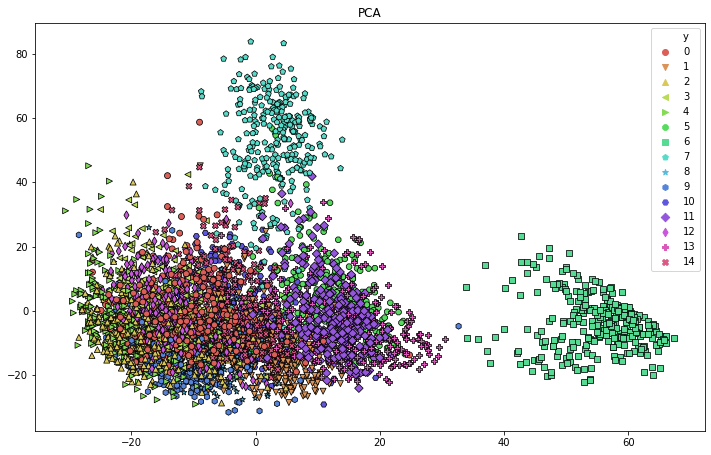

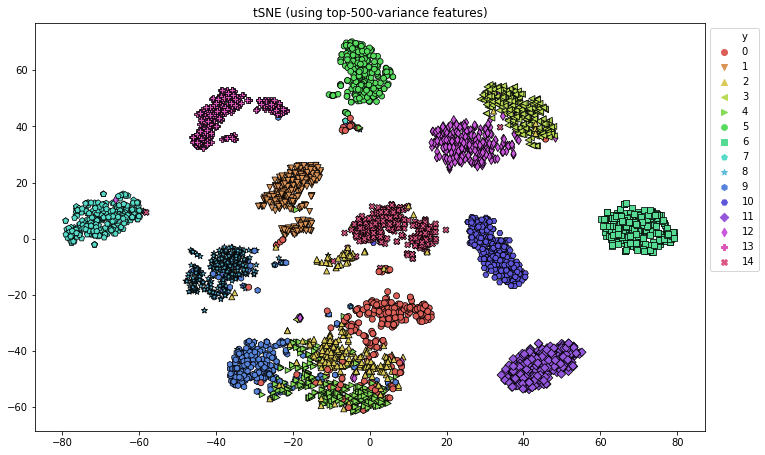

In [11]:
tc1_library.run_and_plot_pca_and_tsne(TC1data15, outcome)

## CONV1D

In [ ]:
X_train_selected_pca = pd.read_csv("X_train_selected_pca.tsv", low_memory=False, sep="\t")
X_train_selected_pca = pd.read_csv("X_test_selected_pca.tsv", low_memory=False, sep="\t")

In [ ]:
#X_train_ = X_train
#X_test_ = X_test
X_train = X_train_selected_pca
X_test = X_test_selected_pca

In [ ]:
Y_train = encode(Y_train)
Y_test = encode(Y_test)

In [ ]:
# parameters  
activation='relu'
batch_size=20
# Number of sites
classes=15
drop = 0.1
feature_subsample = 0
loss='categorical_crossentropy'
# metrics='accuracy'
out_act='softmax'
pool=[1, 10]
# optimizer='sgd'
shuffle = False 
epochs=400

optimizer = optimizers.SGD(lr=0.1)
metrics = ['acc']

# X_train shape: (3375, 60483)
# X_test shape:  (1125, 60483)
# Y_train shape: (3375,1)
# Y_test shape:  (1125,1)

# 60483
x_train_len = X_train.shape[1]   

X_train = np.expand_dims(X_train, axis=2)
X_test = np.expand_dims(X_test, axis=2)

# X_train shape: (3375, 60483, 1)
# X_test shape:  (1125, 60483, 1)


filters = 128 
filter_len = 20 
stride = 1 

# inside pool_list loop
pool_list = [1,10]

K.clear_session()

model = Sequential()

# model.add  CONV1D
model.add(Conv1D(filters = filters, 
                 kernel_size = filter_len, 
                 strides = stride, 
                 padding='valid', 
                 input_shape=(x_train_len, 1)))

# x_train_len = 60,483
# Activation
model.add(Activation('relu'))

# MaxPooling
model.add(MaxPooling1D(pool_size = 1))

filters = 128
filter_len = 10 
stride = 1 
# Conv1D
model.add(Conv1D(filters=filters, 
                 kernel_size=filter_len, 
                 strides=stride, 
                 padding='valid'))
# Activation
model.add(Activation('relu'))

# MaxPooling
model.add(MaxPooling1D(pool_size = 10))
model.add(Flatten())

model.add(Dense(200))

# activation 
# model.add(Activation('relu')) # SR
model.add(Activation(activation))
#dropout
model.add(Dropout(0.1))

model.add(Dense(20))
# activation
# model.add(Activation('relu')) # SR
model.add(Activation(activation))

#dropout
model.add(Dropout(0.1))

model.add(Dense(15))
model.add(Activation(out_act))

model.compile( loss= loss, 
              optimizer = optimizer, 
              metrics = metrics )
model.summary()



In [ ]:
# save
save = '.'
output_dir = "/data/ravichandrans/TC1/Modeling"
          
output_dir = save 
if not os.path.exists(output_dir): 
    os.makedirs(output_dir)

model_name = 'tc1'
path = '{}/{}.autosave.model.h5'.format(output_dir, model_name)
checkpointer = ModelCheckpoint(filepath=path, 
                               verbose=1, 
                               save_weights_only=False, 
                               save_best_only=True)
          
csv_logger = CSVLogger('{}/training.log'.format(output_dir))



In [ ]:
# SR: change epsilon to min_delta
reduce_lr = ReduceLROnPlateau(monitor='val_loss', 
                              factor=0.1, 
                              patience=10, 
                              verbose=1, mode='auto', 
                              min_delta=0.0001, 
                              cooldown=0, 
                              min_lr=0)


In [ ]:
# batch_size = 20 
history = model.fit(X_train, Y_train, batch_size=batch_size, 
                    epochs=epochs, verbose=1, validation_data=(X_test, Y_test), 
                    callbacks = [checkpointer, csv_logger, reduce_lr])

score = model.evaluate(X_test, Y_test, verbose=0)

## Finish up save model weights

In [ ]:
print('Test score:', score[0])
print('Test accuracy:', score[1])

# serialize weights to HDF5
model.save_weights("{}/{}.model.h5".format(output_dir, model_name))
print("Saved model to disk")

# load weights into new model
loaded_model_yaml.load_weights('{}/{}.model.h5'.format(output_dir, model_name))
print("Loaded yaml model from disk")

# evaluate loaded model on test data
loaded_model_yaml.compile(loss=loss,optimizer=optimizer, metrics=metrics) 
score_yaml = loaded_model_yaml.evaluate(X_test, Y_test, verbose=0)

print('yaml Test score:', score_yaml[0])
print('yaml Test accuracy:', score_yaml[1])

print("yaml %s: %.2f%%" % (loaded_model_yaml.metrics_names[1], score_yaml[1]*100))



# t-SNE

In [14]:
model = TSNE()
x_tsne = model.fit(X_train)

In [23]:
X_train_selected_tsne = x_tsne.transform(X_train)
X_test_selected_tsne = x_tsne.transform(X_test)

AttributeError: 'TSNE' object has no attribute 'transform'

In [18]:
X_train_selected_tsne = pd.DataFrame(X_train_selected_tsne)
X_test_selected_tsne = pd.DataFrame(X_test_selected_tsne)

In [ ]:
plt.scatter(xs, ys, c = ys_fit, alpha = 0.5);

# NVR (neighborhood variance ratio)

In [ ]:
sc.pp.normalize_total(X_train,max_fraction = 0, target_sum = 1)
nvr.arcsinh_transform(X_train)


In [ ]:
X_train_nvr = nvr.nvr_feature_select(X_train)


In [ ]:
x_train_selected_nvr = X_train_nvr.var[X_train_nvr.uns['NVR_genes']]